<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/physinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# Parameters
zeta = 0.1       # Damping ratio
omega0 = 2.0     # Natural frequency
y0 = 1.0         # Initial displacement
v0 = 0.0         # Initial velocity
T = 10.0         # Total simulation time
dt = 0.01        # Time step

In [113]:
# Initialize arrays
t = np.arange(0, T, dt)
y = np.zeros_like(t)
v = np.zeros_like(t)
y[0], v[0] = y0, v0

# Euler method
for i in range(1, len(t)):
    y[i] = y[i-1] + v[i-1] * dt
    v[i] = v[i-1] + (-2 * zeta * omega0 * v[i-1] - omega0**2 * y[i-1]) * dt

In [114]:
class Neural_ODE:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # He initialization for ReLU
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
        self.b3 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, X):
        # Layer 1
        self.hidden1 = self.relu(np.dot(X, self.W1) + self.b1)
        # Layer 2
        self.hidden2 = self.relu(np.dot(self.hidden1, self.W2) + self.b2)
        # Output (linear activation for regression)
        self.output = np.dot(self.hidden2, self.W3) + self.b3
        return self.output

    def backward(self, X, y_true, y_pred, lr):
        m = X.shape[0]  # Batch size

        # Output layer gradient
        error = y_pred - y_true
        dW3 = np.dot(self.hidden2.T, error) / m
        db3 = np.sum(error, axis=0, keepdims=True) / m

        # Hidden layer 2 gradient
        dhidden2 = np.dot(error, self.W3.T) * (self.hidden2 > 0)  # ReLU derivative
        dW2 = np.dot(self.hidden1.T, dhidden2) / m
        db2 = np.sum(dhidden2, axis=0, keepdims=True) / m

        # Hidden layer 1 gradient
        dhidden1 = np.dot(dhidden2, self.W2.T) * (self.hidden1>0)  # Relu derivative
        dW1 = np.dot(X.T, dhidden1) / m
        db1 = np.sum(dhidden1, axis=0, keepdims=True) / m

        # Update weights
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3

    def train(self, X, y, lr=0.1, epochs=10000):
        losses = []
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)

            # Loss (MSE)
            loss = np.mean((y_pred - y) ** 2)
            losses.append(loss)

            # Backward pass
            self.backward(X, y, y_pred, lr)

            if epoch % 500 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return losses

In [115]:
# Prepare data (normalize time)
t_normalized = t / T  # Scale time to [0, 1]
X_train = t_normalized.reshape(-1, 1)
y_train = y.reshape(-1, 1)

In [116]:
# Initialize and train NN
nn = Neural_ODE(input_size=1, hidden1_size=64, hidden2_size=64, output_size=1)
losses = nn.train(X_train, y_train, lr=0.19, epochs=10000)

# Predictions
y_nn = nn.forward(X_train)

Epoch 0, Loss: 1.1545
Epoch 500, Loss: 0.0976
Epoch 1000, Loss: 0.0826
Epoch 1500, Loss: 0.0437
Epoch 2000, Loss: 0.0160
Epoch 2500, Loss: 0.0104
Epoch 3000, Loss: 0.0074
Epoch 3500, Loss: 0.0052
Epoch 4000, Loss: 0.0041
Epoch 4500, Loss: 0.0030
Epoch 5000, Loss: 0.0025
Epoch 5500, Loss: 0.0020
Epoch 6000, Loss: 0.0017
Epoch 6500, Loss: 0.0014
Epoch 7000, Loss: 0.0013
Epoch 7500, Loss: 0.0012
Epoch 8000, Loss: 0.0011
Epoch 8500, Loss: 0.0010
Epoch 9000, Loss: 0.0007
Epoch 9500, Loss: 0.0009


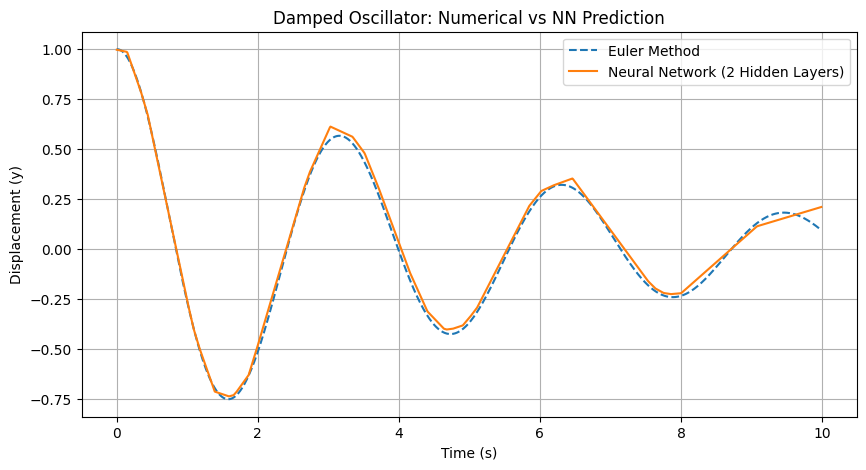

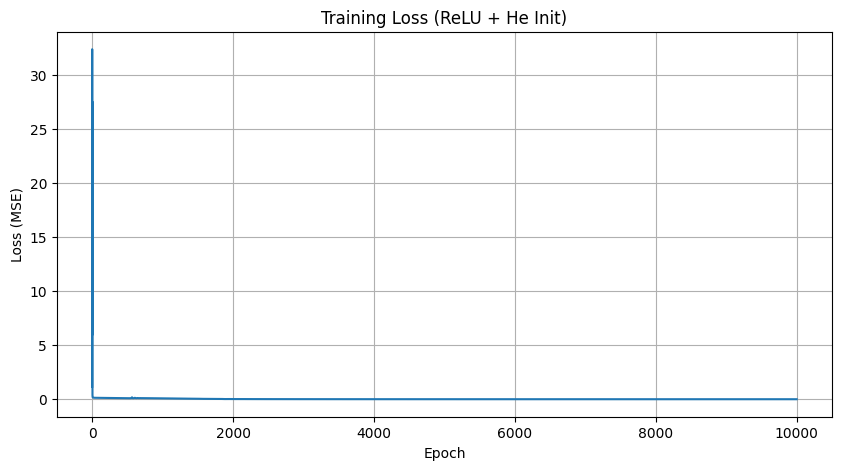

In [117]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, y, label="Euler Method", linestyle="--")
plt.plot(t, y_nn, label="Neural Network (2 Hidden Layers)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (y)")
plt.title("Damped Oscillator: Numerical vs NN Prediction")
plt.legend()
plt.grid()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss (ReLU + He Init)")
plt.grid()
plt.show()